In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from IPython.display import clear_output

# DATA PREPROCESSING

In [2]:
investments = pd.read_csv('investments.csv')
investments = investments[['company_name', 'company_category_list', 'investor_name', 'funding_round_type', 'funding_round_code', 'company_country_code', 'investor_country_code']]

In [3]:
# remove values with nan company names
investments = investments[(investments[['company_name']].notnull())['company_name']]

# remove values with nan investor names
investments = investments[(investments[['investor_name']].notnull())['investor_name']]

# remove values that are both investors and companies; we want to construct a bipartite graph
common_values = set(investments['company_name']).intersection(set(investments['investor_name']))
investments = investments[~investments['company_name'].isin(common_values)]
investments = investments[~investments['investor_name'].isin(common_values)]

# reindex table so row indices are in sequential order
investments = investments.reset_index(drop=True)

# GRAPH CONSTRUCTION

In [4]:
list_of_companies = set(investments['company_name'])
company_idx_node_dict = dict(zip(range(len(list_of_companies)), list_of_companies))
company_node_idx_dict = dict(zip(list_of_companies, range(len(list_of_companies))))

list_of_investors = set(investments['investor_name'])
investor_idx_node_dict = dict(zip(range(len(list_of_companies), len(list_of_companies)+len(list_of_investors)), list_of_investors))
investor_node_idx_dict = dict(zip(list_of_investors, range(len(list_of_companies), len(list_of_companies)+len(list_of_investors))))

In [5]:
edge_list = []
for row_idx in range(len(investments)):
    company = investments.loc[row_idx]['company_name']
    investor = investments.loc[row_idx]['investor_name']
    
    edge_list.append((investor_node_idx_dict[investor], company_node_idx_dict[company]))

In [6]:
g_bipartite = nx.Graph()
g_bipartite.add_nodes_from(list(company_idx_node_dict.keys()), bipartite=0)
g_bipartite.add_nodes_from(list(investor_idx_node_dict.keys()), bipartite=1)

g_bipartite.add_edges_from(edge_list)

nx.write_edgelist(g_bipartite, "investor_company_bipartite.edgelist")

In [7]:
nx.number_of_nodes(g_bipartite),nx.number_of_edges(g_bipartite),nx.number_of_selfloops(g_bipartite),nx.number_connected_components(g_bipartite)

(71160, 124564, 0, 4111)

In [8]:
giant = max(nx.connected_component_subgraphs(g_bipartite), key=len)
nx.number_of_nodes(giant), nx.number_of_edges(giant)

(60141, 117629)

In [9]:
g_bipartite_giant = nx.Graph()
g_bipartite_giant.add_nodes_from(list(set(company_idx_node_dict.keys()).intersection(set(giant.nodes()))), bipartite=0)
g_bipartite_giant.add_nodes_from(list(set(investor_idx_node_dict.keys()).intersection(set(giant.nodes()))), bipartite=1)

g_bipartite_giant.add_edges_from(list(giant.edges()))

nx.write_edgelist(g_bipartite_giant, "investor_company_bipartite_giant.edgelist")

nx.number_connected_components(g_bipartite_giant)

1

In [44]:
g_bipartite_giant_2core = nx.k_core(g_bipartite_giant, k=2)
nx.number_of_nodes(g_bipartite_giant_2core), nx.number_of_edges(g_bipartite_giant_2core)

In [46]:
# get one mode projections

company_nodes = set(n for n,d in g_bipartite_giant_2core.nodes(data=True) if d['bipartite']==0)
investor_nodes = set(g_bipartite_giant_2core) - company_nodes

g_company = nx.bipartite.projected_graph(g_bipartite_giant_2core, company_nodes)
g_investor = nx.bipartite.projected_graph(g_bipartite_giant_2core, investor_nodes)

In [95]:
nx.write_edgelist(g_company, 'company.edgelist')
nx.write_edgelist(g_investor, 'investor.edgelist')
nx.write_edgelist(g_bipartite_giant_2core, '2core.edgelist')

In [91]:
nx.average_clustering(g_company)

0.5704269738310974

In [92]:
nx.average_clustering(g_investor)

0.44491855718273055

In [93]:
nx.average_clustering(g_bipartite_giant_2core)

0.0

In [94]:
nx.diameter(g_company) 

KeyboardInterrupt: 

In [ ]:
nx.diameter(g_investor)

In [ ]:
nx.diameter(g_bipartite_giant_2core)

# DEGREE DISTRIBUTION

In [81]:
degree_dict = dict(nx.degree(g_bipartite_giant_2core))

degrees, degree_counts = np.unique(list(degree_dict.values()), return_counts = True)
p_k = degree_counts / g_bipartite_giant_2core.number_of_nodes()

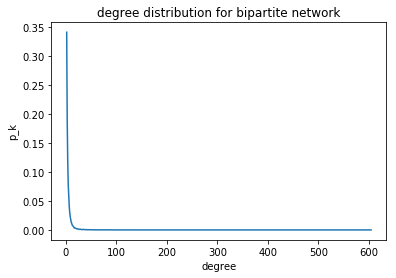

In [82]:
#degree dist
plt.plot(degrees, p_k)
plt.title('degree distribution for bipartite network')
plt.xlabel('degree')
plt.ylabel('p_k')
plt.show()

In [86]:
degree_dict = dict(nx.degree(g_company))

degrees, degree_counts = np.unique(list(degree_dict.values()), return_counts = True)
p_k = degree_counts / g_company.number_of_nodes()

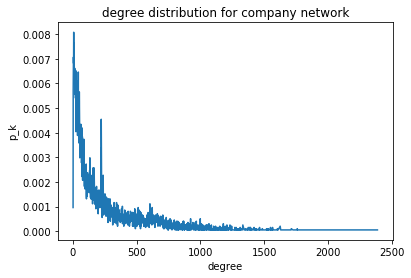

In [88]:
#degree dist
plt.plot(degrees, p_k)
plt.title('degree distribution for company network')
plt.xlabel('degree')
plt.ylabel('p_k')
plt.show()

In [89]:
degree_dict = dict(nx.degree(g_investor))

degrees, degree_counts = np.unique(list(degree_dict.values()), return_counts = True)
p_k = degree_counts / g_investor.number_of_nodes()

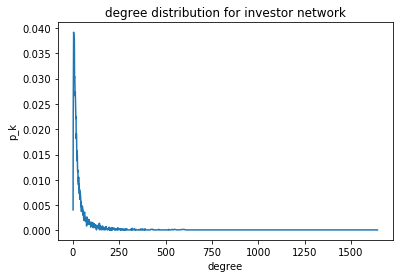

In [90]:
#degree dist
plt.plot(degrees, p_k)
plt.title('degree distribution for investor network')
plt.xlabel('degree')
plt.ylabel('p_k')
plt.show()

In [ ]:
power law fit etc

In [ ]:
g = nx.Graph()
g.add_nodes_from(set(company_idx_node_dict.keys()).union(investor_idx_node_dict.keys()))
g.add_edges_from(edge_list)

nx.write_edgelist(g, "investor_company.edgelist")

nx.number_of_nodes(g),nx.number_of_edges(g),nx.number_of_selfloops(g),nx.number_connected_components(g)

degree_dict = dict(nx.degree(g))

degrees, degree_counts = np.unique(list(degree_dict.values()), return_counts = True)
p_k = degree_counts / g.number_of_nodes()


#degree dist
plt.bar(degrees, p_k)
plt.show()